First, let's consider what happens in the absence of the Hessian distortion. In particular, let's set our parameters so we observe an Einstein ring (this is a very slightly modified version of the lenstronomy microlensing tutorial.)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# define the microlens

# =========
# distances
# =========

d_l = 4000  # distance of the lens in pc
d_s = 8000  # distance of the source in pc

# ===========
# lens
# ===========

M0 = 0.01  # mass of the main lens in units of M_sol

# ===========
# source size
# ===========

diameter_s = 1  # size of the radius of the source star in units of the solar radius

In [3]:
# compute lensing properties
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size

theta_E = einstein_radius(M0, d_l, d_s)
print(theta_E, 'Einstein radius [arc seconds]')

size_s = source_size(diameter_s, d_s)
print(size_s, 'source size in arc seconds')

0.00010090910723578977 Einstein radius [arc seconds]
1.163118159836867e-06 source size in arc seconds


In [4]:
# compute ray-tracing grid

grid_scale = size_s / 10 # ten times the source size resolution
grid_width = theta_E * 4
num_pix = int(grid_width / grid_scale)
print(num_pix)

from lenstronomy.Util import util
x, y = util.make_grid(numPix=num_pix, deltapix=grid_scale)

3470


In [5]:
# map image to source plane
from lenstronomy.LensModel.lens_model import LensModel
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

# compute surface brightness
from lenstronomy.LightModel.light_model import LightModel
light = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': size_s/2 * 10, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

unlensed_surface_brightness = light.surface_brightness(x, y, kwargs_light)
lensed_surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
total_unlensed_surface_brightness = np.sum(unlensed_surface_brightness)

unlensed_image = util.array2image(unlensed_surface_brightness)
lensed_image = util.array2image(lensed_surface_brightness)

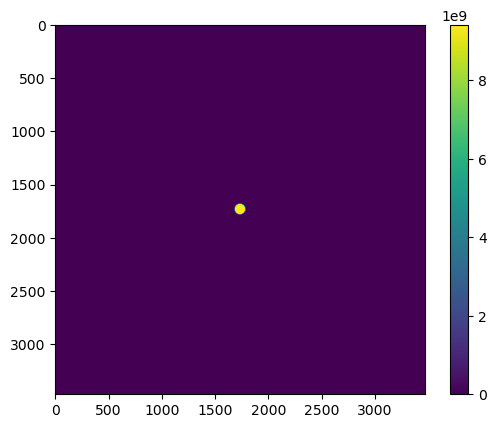

In [6]:
# display the unlensed image
plt.imshow(unlensed_image)
plt.colorbar()
plt.show()

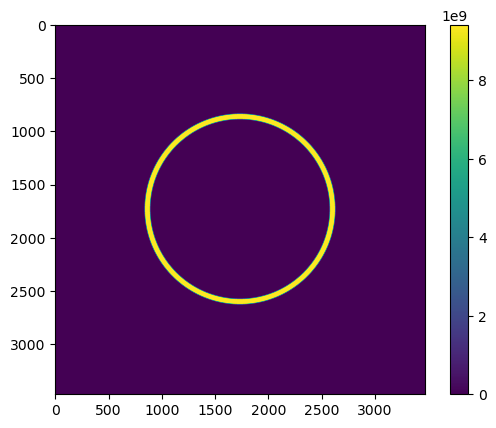

In [7]:
# display the lensed image
plt.imshow(lensed_image)
plt.colorbar()
plt.show()

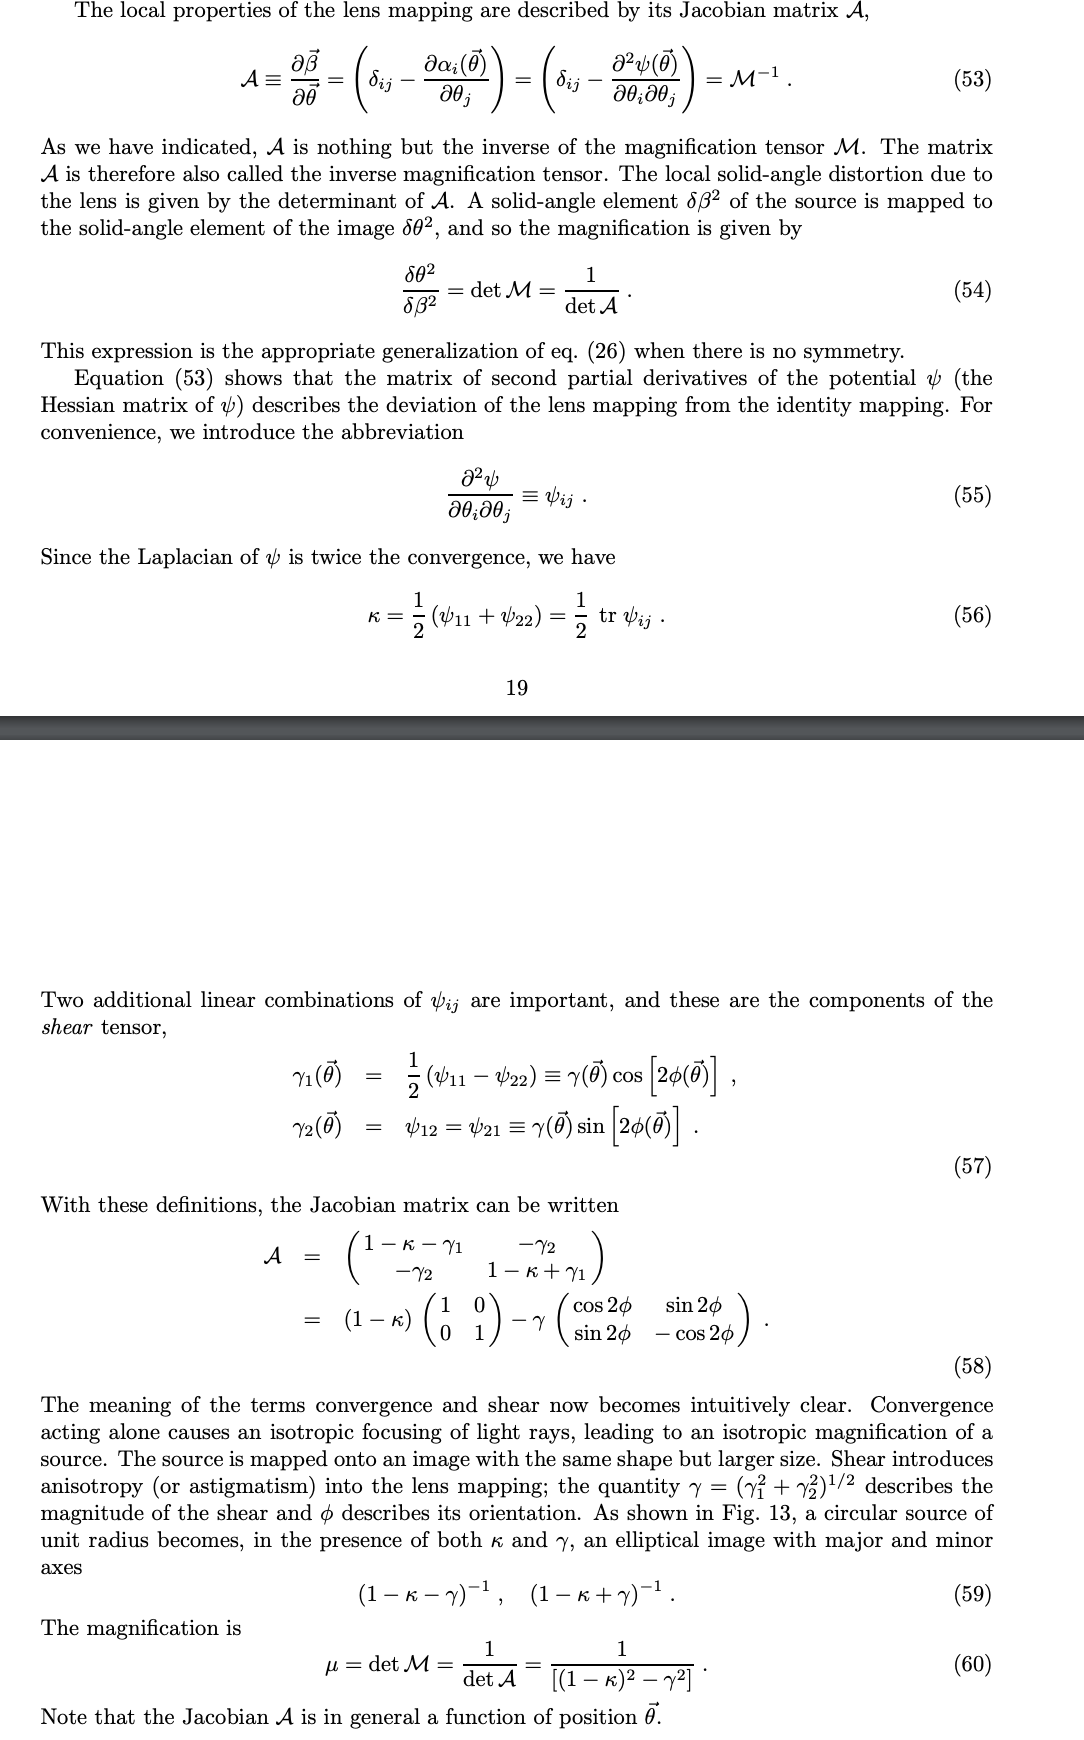

Rearranging eqs. (56) and (57) gives us the Hessian in terms of the convergence and the shear, 

$$H = \begin{pmatrix}
\kappa + \gamma_1 & \gamma_2 \\
\gamma_2 & \kappa-\gamma_1
\end{pmatrix}$$. 

Let's use our formalism to predict some imaging results for some example Hessians. We start from the Hessian components rather than the convergence and the shear directly because the second derivatives are what we actually input into the $\texttt{LensModel.Hessian()}$

- If $H =  \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}$, then $\kappa = 1$ and $\gamma = 0$, so (58) says that the image should vanish.
- If $H =  \begin{pmatrix}
0 & 0 \\
0 & 0
\end{pmatrix}$, then $\kappa = \gamma = 0$, so (58) says that the image should be unchanged.
- If $H =  \begin{pmatrix}
0.5 & 0 \\
0 & 0.5
\end{pmatrix}$, then $\kappa = 0.5$ and $\gamma = 0$, so (58) says that the image should be isotropically magnified, and (60) gives the magnification factor as $4$.
- If $H =  \begin{pmatrix}
0.4 & 0.4 \\
0.4 & -0.4
\end{pmatrix}$, then $\kappa = 0$ and $\gamma_1 = \gamma_2 = 0.4 \rightarrow \gamma = \sqrt{0.4^2 + 0.4^2} \approx 0.57$, so (58) says that the image should be anistropically magnified, and (60) gives the magnification factor as $\approx 1.47$. From (57) we see that $\tan 2\phi = \gamma_2/\gamma_1 \rightarrow \tan 2\phi = 1 \rightarrow \phi = 45^{\circ}$, so the shear should be at $45^{\circ}$.

Now, let's test these predictions, using the same source as before.

In [8]:
def hessian_distortion_image_generator(f_xx, f_yy, f_xy, f_yx):
    
    # light model for source inherited from the above

    from lenstronomy.LensModel.lens_model import LensModel
    lens = LensModel(lens_model_list=['HESSIAN'])
    kwargs_lens = [{"f_xx": f_xx, "f_yy": f_yy, "f_xy": f_xy, "f_yx": f_yx, "ra_0": 0, "dec_0": 0}]
    beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

    lensed_surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
    lensed_image = util.array2image(lensed_surface_brightness)
    
    magnification = np.sum(lensed_surface_brightness) / total_unlensed_surface_brightness
    
    plt.imshow(lensed_image) 
    plt.colorbar() 
    plt.show()
    
    return magnification

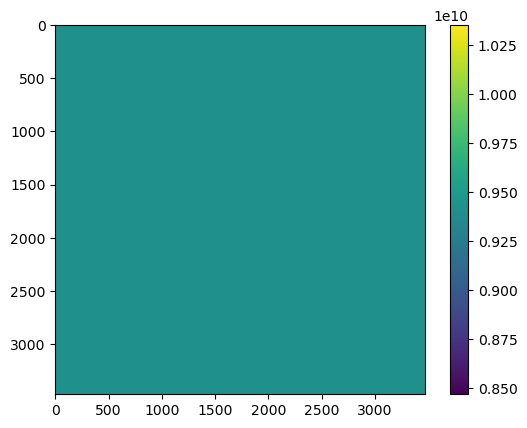

1531.9211195929206

In [9]:
hessian_distortion_image_generator(1,1,0,0)
# what's going on here? 

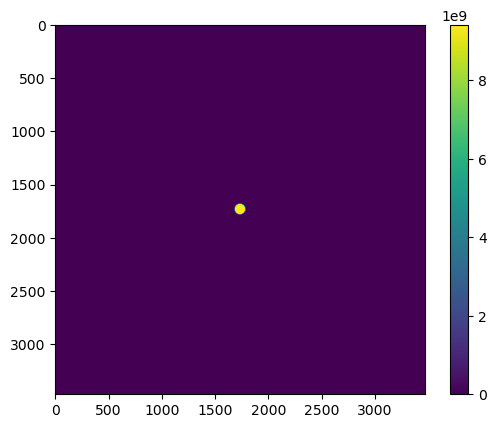

1.0

In [10]:
hessian_distortion_image_generator(0,0,0,0)

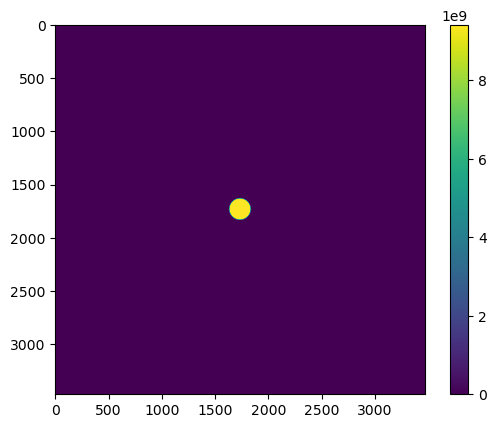

3.9984732824427476

In [11]:
hessian_distortion_image_generator(0.5,0.5,0,0)

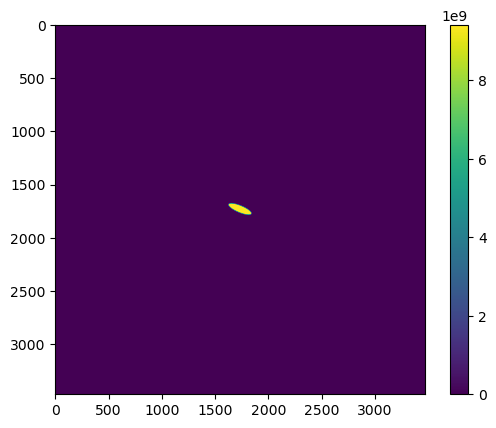

1.4692111959287535

In [12]:
hessian_distortion_image_generator(0.4,-0.4,0.4,0.4)

Now, let's do an example where we combine the point mass lens and the Hessian distortion, using the same source light model as above

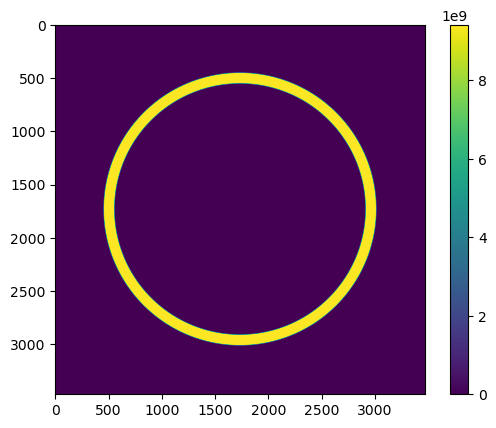

In [13]:
# in this example, we isotropically magnify the Einstein ring
from lenstronomy.LensModel.lens_model import LensModel
lens = LensModel(lens_model_list=['POINT_MASS', 'HESSIAN'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}, {"f_xx": 0.5, "f_yy": 0.5, "f_xy": 0, "f_yx": 0, "ra_0": 0, "dec_0": 0}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

lensed_surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
lensed_image = util.array2image(lensed_surface_brightness)

plt.imshow(lensed_image) 
plt.colorbar() 
plt.show()

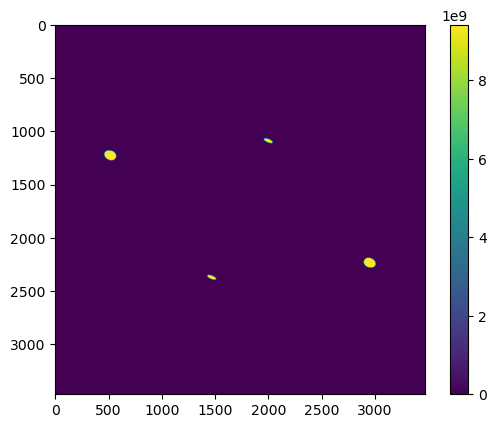

In [14]:
# in this example, we break the Einstein ring by shearing
from lenstronomy.LensModel.lens_model import LensModel
lens = LensModel(lens_model_list=['POINT_MASS', 'HESSIAN'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}, {"f_xx": 0.4, "f_yy": -0.4, "f_xy": 0.4, "f_yx": 0.4, "ra_0": 0, "dec_0": 0}]
beta_x, beta_y = lens.ray_shooting(x, y, kwargs=kwargs_lens)

lensed_surface_brightness = light.surface_brightness(beta_x, beta_y, kwargs_light)
lensed_image = util.array2image(lensed_surface_brightness)

plt.imshow(lensed_image) 
plt.colorbar() 
plt.show()